# Data Analysis-- Supervised Learning
* Created on Feb 6, 2023 by Shangying Wang
* Last Modified: Feb 13, 2023 by Jie Shi
* this code is used for prediction of the mean fold change from the overexpression of genes and/or knockout of genes
* this code used CNN and CNN+LSTM

In [1]:
%load_ext autoreload
%autoreload 2
from mylib import *

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import csv
import os
import matplotlib.pyplot as plt
from itertools import product, combinations
%matplotlib inline

In [3]:
from tensorflow.keras.optimizers import SGD, Adam
from keras import layers,Sequential
from keras.layers import Input, Dense, Dropout, Flatten, Average, BatchNormalization, LSTM, TimeDistributed
from tensorflow.keras.layers import Conv1D,MaxPool1D, concatenate, Reshape
from keras.initializers import RandomNormal,HeNormal,GlorotNormal,HeUniform,LecunNormal,LecunUniform,Orthogonal
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler
from itertools import product
from sklearn import metrics
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV

# For peroxisome data analysis

1. There are 25 overexpressed genes;
2. There are 23 genes that have a delta sign in front of the gene name. This means that those genes were knocked out or removed from the genome;
3. The last column is the main output - it shows the fold change for that case compared to WT;

## Load data from file

In [4]:
all_data=pd.read_csv('data/all_data_duplicated_removed_139samples_before_cleaning_first_round.csv',sep=',')
#all_data=pd.read_csv('../data/all_data_duplicated_removed.csv',sep=',')
#all_data.drop(['Case #', 'OE/KO test case average (Relative fluorescence units/ Optical density)', 'OE/KO test case standard deviation', 'WT average (Relative fluorescence units/ Optical density)', 'WT standard deviation'], axis=1, inplace=True)
all_data.drop(['Unnamed: 0','capacity_std','capacity_instances'], axis=1, inplace=True)
all_data

,Pex1,Pex2,Pex3,Pex4,Pex5,Pex6,Pex8,Pex10,Pex11,Pex12,...,ΔAtg15,ΔVps1,ΔTgl1,ΔTgl5,ΔPex29,ΔMmm1,ΔMdm10,ΔMdm12,ΔInp2,capacity_mean
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.5700
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1.2850
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0.9400
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1.2400
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1.1733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,2.5400
135,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,1.6500
136,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,2.4800
137,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,1.8600


In [5]:
all_data.columns

Index(['Pex1', 'Pex2', 'Pex3', 'Pex4', 'Pex5', 'Pex6', 'Pex8', 'Pex10',
       'Pex11', 'Pex12', 'Pex13', 'Pex14', 'Pex15', 'Pex17', 'Pex19', 'Pex22',
       'Pex25', 'Pex27', 'Pex28', 'Pex29', 'Pex30', 'Pex31', 'Pex32', 'Pex34',
       'Sei1', 'Rtn1', 'Vps1', 'Ant1', 'Arf3', 'Cbf1', 'Mig3', 'ΔPex9',
       'ΔPex11', 'ΔPex31', 'ΔPex32', 'ΔPex27', 'ΔAtg11', 'ΔAtg36', 'ΔDoa1',
       'ΔCmp2', 'ΔMsn4', 'ΔTec1', 'ΔHac1', 'ΔRpn4', 'ΔAtg1', 'ΔAtg15', 'ΔVps1',
       'ΔTgl1', 'ΔTgl5', 'ΔPex29', 'ΔMmm1', 'ΔMdm10', 'ΔMdm12', 'ΔInp2',
       'capacity_mean'],
      dtype='object')

In [6]:
# We removed the genes that only show up once, by itself, without any interactions with other genes from the combinatorial screening, i.e., Mig3, Cbf1;
# We also delete Ant1 and Arf3, there is only one data point for the combination of the two genes. Their interactions with other genes are unclear.
# Pex25 genes has 2 data points, both only have pex25 genes. We removed these 2 data points from current analysis.
# Pex27 genes has 2 data points, both only have pex27 genes,We removed these 2 data points from current analysis.
columns_remove = ['Mig3','Cbf1','Ant1','Arf3','Pex25','Pex27', 'ΔPex9',
                  'ΔPex31','ΔPex32','ΔPex27', 'ΔAtg36','ΔCmp2', 'ΔMsn4','ΔTec1','ΔHac1','ΔRpn4','ΔAtg1','ΔAtg15','ΔVps1','ΔTgl5','ΔMmm1','ΔMdm10','ΔInp2']


In [7]:
# Remove rows where any value in each column from your list is not zero
all_data = all_data[(all_data[columns_remove] == 0).all(axis=1)]
# Remove the columns from the list
all_data = all_data.drop(columns=columns_remove)

In [8]:
display(all_data)

,Pex1,Pex2,Pex3,Pex4,Pex5,Pex6,Pex8,Pex10,Pex11,Pex12,...,Sei1,Rtn1,Vps1,ΔPex11,ΔAtg11,ΔDoa1,ΔTgl1,ΔPex29,ΔMdm12,capacity_mean
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1.2850
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1.1733
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1.3400
15,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1.5967
17,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1.7946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,1,0,0,0,0,2.5400
135,1,1,1,1,1,1,1,1,1,1,...,1,1,0,0,0,0,0,0,0,1.6500
136,1,1,1,1,1,1,1,1,1,1,...,1,1,0,0,1,0,0,0,0,2.4800
137,1,1,1,1,1,1,1,1,1,1,...,1,1,0,0,0,0,0,0,0,1.8600


In [9]:
data_head = list(all_data.columns) 
data_head

['Pex1',
 'Pex2',
 'Pex3',
 'Pex4',
 'Pex5',
 'Pex6',
 'Pex8',
 'Pex10',
 'Pex11',
 'Pex12',
 'Pex13',
 'Pex14',
 'Pex15',
 'Pex17',
 'Pex19',
 'Pex22',
 'Pex28',
 'Pex29',
 'Pex30',
 'Pex31',
 'Pex32',
 'Pex34',
 'Sei1',
 'Rtn1',
 'Vps1',
 'ΔPex11',
 'ΔAtg11',
 'ΔDoa1',
 'ΔTgl1',
 'ΔPex29',
 'ΔMdm12',
 'capacity_mean']

In [10]:
#data statistics
stats_df = all_data.describe()
stats_df

,Pex1,Pex2,Pex3,Pex4,Pex5,Pex6,Pex8,Pex10,Pex11,Pex12,...,Sei1,Rtn1,Vps1,ΔPex11,ΔAtg11,ΔDoa1,ΔTgl1,ΔPex29,ΔMdm12,capacity_mean
count,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,...,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000
mean,0.358974,0.299145,0.393162,0.358974,0.615385,0.094017,0.196581,0.299145,0.264957,0.333333,...,0.230769,0.230769,0.008547,0.059829,0.230769,0.034188,0.017094,0.034188,0.017094,1.364730
std,0.481763,0.459853,0.490553,0.481763,0.488597,0.293108,0.399122,0.459853,0.443209,0.473432,...,0.423137,0.423137,0.092450,0.238190,0.423137,0.182493,0.130179,0.182493,0.130179,0.490939
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.175000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.040000
50%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.285000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.680000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.760000


In [11]:
skew_vals=all_data['capacity_mean'].skew()
skew_vals

0.6498831959942142

<AxesSubplot:>

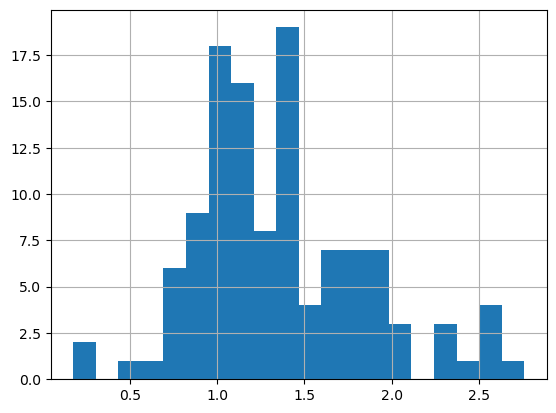

In [12]:
all_data['capacity_mean'].hist(bins=20)

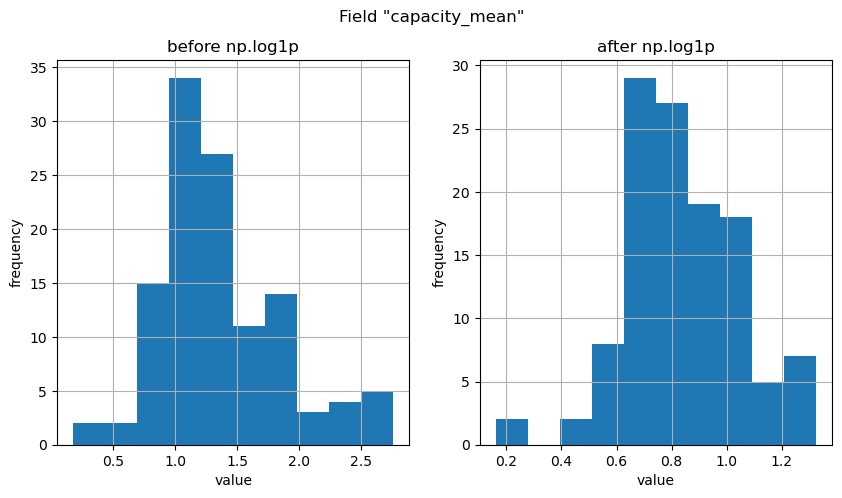

In [13]:
# Let's look at what happens to one of these features, when we apply np.log visually.

# Choose a field
field = "capacity_mean"
# Create two "subplots" and a "figure" using matplotlib
fig, (ax_before, ax_after) = plt.subplots(1, 2, figsize=(10, 5))

# Create a histogram on the "ax_before" subplot
all_data[field].hist(ax=ax_before)

# Apply a log transformation (numpy syntax) to this column
all_data[field].apply(np.log1p).hist(ax=ax_after)

# Formatting of titles etc. for each subplot
ax_before.set(title='before np.log1p', ylabel='frequency', xlabel='value')
ax_after.set(title='after np.log1p', ylabel='frequency', xlabel='value')
fig.suptitle('Field "{}"'.format(field));


In [14]:
skew_vals=np.log1p(all_data['capacity_mean']).skew()
skew_vals

-0.12851866784147378

In [15]:
num_classes=1


In [16]:
max_y=np.max(np.log1p(all_data.iloc[:,-1]),axis=0)
min_y=np.min(np.log1p(all_data.iloc[:,-1]),axis=0)
lims = [np.expm1(min_y), np.expm1(max_y)]

In [17]:
num_overexpress=25
num_knockout=6
total_genes=num_overexpress+num_knockout
gene_num=total_genes
X, Y = all_data.iloc[:, 0:gene_num], np.log1p(all_data.iloc[:, -1])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

In [20]:
test_results = {}

## Deep Neural Network 

## CNN alone

In [21]:
output_dim=1
batch_size=20
model_CNN = Sequential()
model_CNN.add(Reshape((gene_num, num_classes), input_shape=(gene_num,)))
model_CNN.add(Conv1D(filters=16, kernel_size=3,  padding='same', activation='relu'))
model_CNN.add(Flatten())
model_CNN.add(Dense(16*output_dim, activation='relu'))
model_CNN.add(Dropout(0.3))
model_CNN.add(Dense(output_dim))
model_CNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 31, 1)             0         
                                                                 
 conv1d (Conv1D)             (None, 31, 16)            64        
                                                                 
 flatten (Flatten)           (None, 496)               0         
                                                                 
 dense (Dense)               (None, 16)                7952      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 8,033
Trainable params: 8,033
Non-trainabl

2024-06-13 04:05:01.065076: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31010 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0004:04:00.0, compute capability: 7.0
2024-06-13 04:05:01.067999: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 31010 MB memory:  -> device: 1, name: Tesla V100-SXM2-32GB, pci bus id: 0004:05:00.0, compute capability: 7.0
2024-06-13 04:05:01.070641: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 31010 MB memory:  -> device: 2, name: Tesla V100-SXM2-32GB, pci bus id: 0004:06:00.0, compute capability: 7.0
2024-06-13 04:05:01.073292: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 31010 MB memory:  -> device: 3, name: Tesla V100-SXM2-32GB, pci bus id

In [21]:
#### Compile the model
model_CNN.compile(
    #loss=keras.losses.MeanSquaredLogarithmicError(),
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.RMSprop(learning_rate=5e-4),
    #optimizer=tfa.optimizers.RectifiedAdam(lr=1e-3),
    #optimizer=Adam(lr=0.0001), #Adam optimizer
    #optimizer=SGD(lr=0.001, momentum=0.99),
    metrics=[tf.keras.metrics.MeanSquaredError()])

history = model_CNN.fit(X_train, Y_train, batch_size=batch_size,  epochs=650,verbose=1)


Epoch 1/650


2024-05-10 20:39:53.232928: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101
2024-05-10 20:39:57.311361: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-10 20:39:57.312159: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-10 20:39:57.312183: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2024-05-10 20:39:57.313056: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-10 20:39:57.313146: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


6/6 [==============================] - 10s 5ms/step - loss: 0.4744 - mean_squared_error: 0.4744
Epoch 2/650
6/6 [==============================] - 0s 3ms/step - loss: 0.2547 - mean_squared_error: 0.2547
Epoch 3/650
6/6 [==============================] - 0s 3ms/step - loss: 0.1495 - mean_squared_error: 0.1495
Epoch 4/650
6/6 [==============================] - 0s 3ms/step - loss: 0.1280 - mean_squared_error: 0.1280
Epoch 5/650
6/6 [==============================] - 0s 3ms/step - loss: 0.1174 - mean_squared_error: 0.1174
Epoch 6/650
6/6 [==============================] - 0s 3ms/step - loss: 0.1137 - mean_squared_error: 0.1137
Epoch 7/650
6/6 [==============================] - 0s 3ms/step - loss: 0.1044 - mean_squared_error: 0.1044
Epoch 8/650
6/6 [==============================] - 0s 3ms/step - loss: 0.0925 - mean_squared_error: 0.0925
Epoch 9/650
6/6 [==============================] - 0s 3ms/step - loss: 0.0865 - mean_squared_error: 0.0865
Epoch 10/650
6/6 [==============================

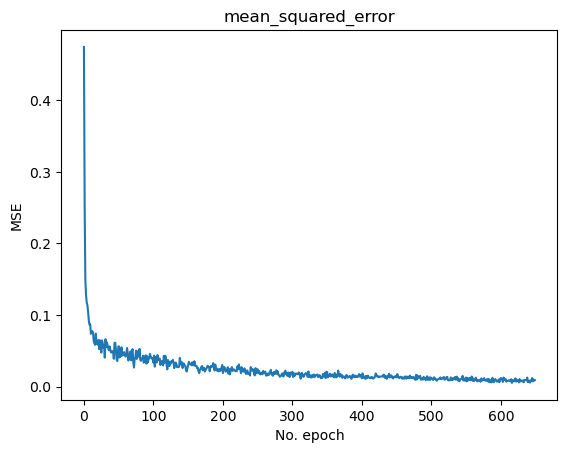

In [22]:
p1=plt.plot(history.history['mean_squared_error'])
plt.title('mean_squared_error')
plt.ylabel('MSE')
plt.xlabel('No. epoch')
plt.show()

In [23]:
y_pred_train = model_CNN.predict(X_train)
y_pred_test = model_CNN.predict(X_test)
test_results['CNN_model'] = metrics.mean_squared_error(Y_test, y_pred_test)

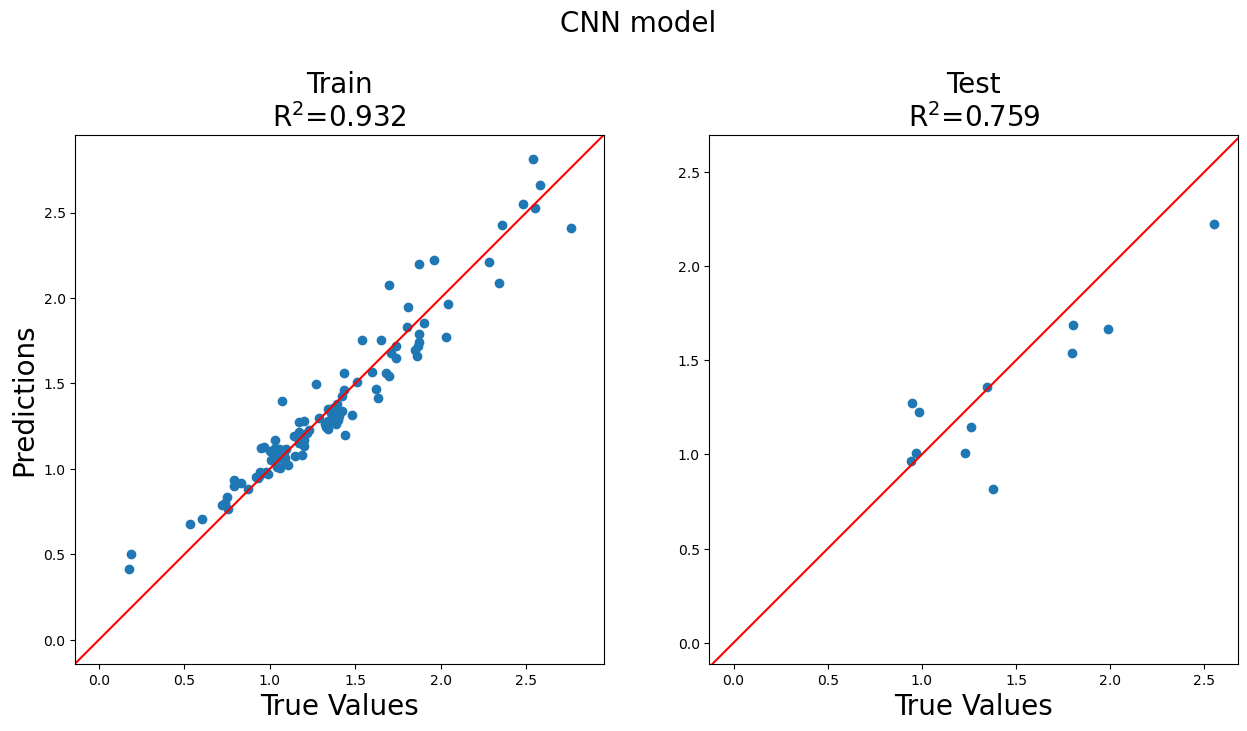

In [24]:
model_name = "CNN model"

plot_train_test(model_name,Y_train,y_pred_train,Y_test,y_pred_test)

## Grid searching

In [21]:
def build_cnn_model(conv_layers=1, dense_layers=1,filters=16,kernel_size=3,dense_units=16,dropout_rate=0.3,learning_rate=5e-4):
    model_cnn = Sequential()
    model_cnn.add(Reshape((gene_num, num_classes), input_shape=(gene_num,)))

    for _ in range(conv_layers):
        model_cnn.add(Conv1D(filters=filters, kernel_size=kernel_size,  padding='same', activation='relu'))
    model_cnn.add(Flatten())
    for _ in range(dense_layers):
        model_cnn.add(Dense(dense_units, activation='relu'))
    model_cnn.add(Dropout(dropout_rate))
    model_cnn.add(Dense(1))
    model_cnn.compile(loss=keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.MeanSquaredError()],
                      optimizer=keras.optimizers.RMSprop(learning_rate=learning_rate))
    return model_cnn

In [26]:
# KerasRegressor is deprecated, use Sci-Keras
#from keras.wrappers.scikit_learn import KerasRegressor
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from keras.callbacks import EarlyStopping


model_cnn_grid = KerasRegressor(model=build_cnn_model, 
                                     conv_layers=1, 
                                     dense_layers=1,
                                     filters=16,
                                     kernel_size=3,
                                     dense_units=16,
                                     dropout_rate=0.3,
                                     learning_rate=5e-4,
                                     epochs=700, batch_size=20, verbose=1) ## model parameter is needed

# full param grid:
param_grid = {
    'conv_layers': [1,2,3],
    'filters': [8, 16, 32], 
    'kernel_size': [1, 3, 5],
#    'lstm_units': [2, 4, 8], # LSTM units
    'dense_units': [8, 16, 32], # Dense layer units
    'learning_rate': [5e-4, 1e-3, 2e-3], # Learning rate
}

#cnn_grid = GridSearchCV(estimator=model_cnn_grid, param_grid=param_grid, cv=2,scoring=new_score,verbose=1)  # verbose 
cnn_grid = GridSearchCV(estimator=model_cnn_grid, param_grid=param_grid, cv=3,verbose=1)  # verbose 

In [ ]:
cnn_hist = cnn_grid.fit(X_train, Y_train, validation_data=(X_test, Y_test),
                      callbacks=[EarlyStopping(patience=70)],verbose=0)

In [28]:
# Best parameters found
print("Best: %f using %s" % (cnn_hist.best_score_, cnn_hist.best_params_))

Best: 0.317060 using {'conv_layers': 1, 'dense_units': 32, 'filters': 16, 'kernel_size': 3, 'learning_rate': 0.001}


In [22]:
best_params = {'conv_layers': 1, 'dense_units': 32, 'filters': 16, 'kernel_size': 3, 'learning_rate': 0.001}

In [ ]:
# use build_cnn_model
#model_CNN_best = build_cnn_model(**cnn_hist.best_params_)
model_CNN_best = build_cnn_model(**best_params)
history = model_CNN_best.fit(X_train, Y_train, batch_size=batch_size,  epochs=500,verbose=1)



Epoch 1/500
6/6 [==============================] - 1s 3ms/step - loss: 0.4384 - mean_squared_error: 0.4384
Epoch 2/500
6/6 [==============================] - 0s 3ms/step - loss: 0.1496 - mean_squared_error: 0.1496
Epoch 3/500
6/6 [==============================] - 0s 3ms/step - loss: 0.1227 - mean_squared_error: 0.1227
Epoch 4/500
6/6 [==============================] - 0s 3ms/step - loss: 0.0885 - mean_squared_error: 0.0885
Epoch 5/500
6/6 [==============================] - 0s 3ms/step - loss: 0.0880 - mean_squared_error: 0.0880
Epoch 6/500
6/6 [==============================] - 0s 3ms/step - loss: 0.0892 - mean_squared_error: 0.0892
Epoch 7/500
6/6 [==============================] - 0s 3ms/step - loss: 0.0768 - mean_squared_error: 0.0768
Epoch 8/500
6/6 [==============================] - 0s 3ms/step - loss: 0.0912 - mean_squared_error: 0.0912
Epoch 9/500
6/6 [==============================] - 0s 3ms/step - loss: 0.0575 - mean_squared_error: 0.0575
Epoch 10/500
6/6 [===================

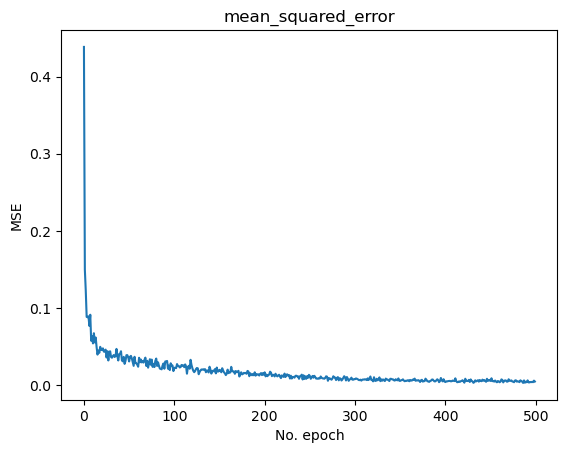

In [ ]:
p1=plt.plot(history.history['mean_squared_error'])
#p2=plt.plot(history.history['val_mean_squared_error'])
plt.title('mean_squared_error')
plt.ylabel('MSE')
plt.xlabel('No. epoch')
#plt.yscale('log')
#plt.legend([p1,p2], ['training','validation'])
plt.show()

In [67]:
y_pred_train = model_CNN_best.predict(X_train)
y_pred_test = model_CNN_best.predict(X_test)


In [27]:
mse = calculate_mse(Y_test,y_pred_test)
mae = calculate_mae(Y_test,y_pred_test)
r2 = calculate_r2(Y_test,y_pred_test)
print(f'mse: {mse}\n mae: {mae}\n r2: {r2}')

mse: 0.047118878780585106
 mae: 0.1682824757019679
 r2: 0.8438465898775319


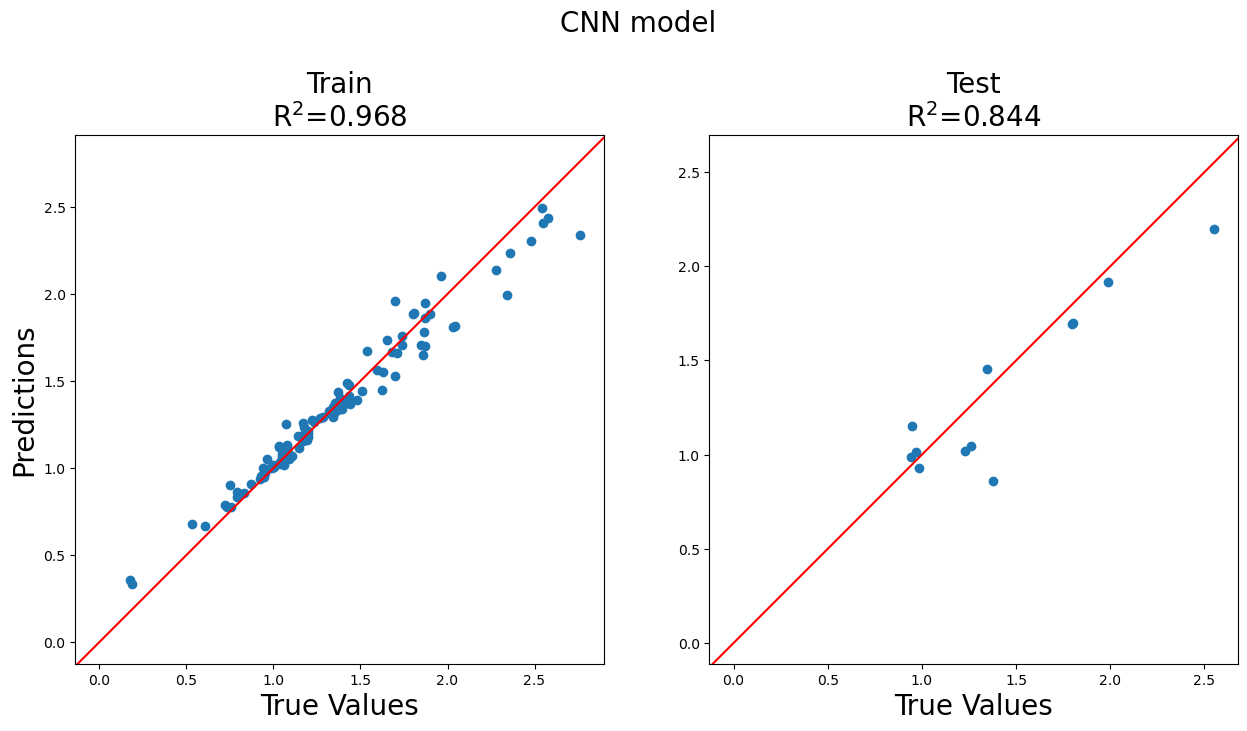

In [28]:
model_name = "CNN model"

plot_train_test(model_name,Y_train,y_pred_train,Y_test,y_pred_test)

## CNN+LSTM

In [20]:
output_dim=1
batch_size=20
#define two sets of inputs
#64, 4, 0.1, 64,0.5,4
#input_position=Input(shape=(gene_num, num_classes), name='input_position')
input_position = Input(shape=(gene_num,), name='input_position')
reshaped_input = Reshape((gene_num, num_classes))(input_position)
#initializer = HeNormal(seed=42)#kernel_initializer=initializer, 
x=Conv1D(filters=16, kernel_size=3, padding='same', activation='relu')(reshaped_input)
x=Conv1D(filters=16, kernel_size=3, padding='same', activation='relu')(x)
x=LSTM(4,return_sequences=True, dropout=0.3)(x)#return_sequences=True,
x = Flatten()(x)
x = Dense(16*output_dim, activation='relu')(x)
x = Dropout(0.3)(x)

z = Dense(output_dim)(x)
model_cnn_lstm = keras.Model(inputs=input_position,outputs=z)
model_cnn_lstm.summary()


2024-05-19 18:44:27.205095: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31010 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0004:04:00.0, compute capability: 7.0
2024-05-19 18:44:27.207982: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 31010 MB memory:  -> device: 1, name: Tesla V100-SXM2-32GB, pci bus id: 0004:05:00.0, compute capability: 7.0
2024-05-19 18:44:27.210640: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 31010 MB memory:  -> device: 2, name: Tesla V100-SXM2-32GB, pci bus id: 0004:06:00.0, compute capability: 7.0
2024-05-19 18:44:27.213286: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 31010 MB memory:  -> device: 3, name: Tesla V100-SXM2-32GB, pci bus id

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_position (InputLayer)  [(None, 31)]             0         
                                                                 
 reshape (Reshape)           (None, 31, 1)             0         
                                                                 
 conv1d (Conv1D)             (None, 31, 16)            64        
                                                                 
 conv1d_1 (Conv1D)           (None, 31, 16)            784       
                                                                 
 lstm (LSTM)                 (None, 31, 4)             336       
                                                                 
 flatten (Flatten)           (None, 124)               0         
                                                                 
 dense (Dense)               (None, 16)                2000  

In [ ]:
#### Compile the model
model_cnn_lstm.compile(
    #loss=keras.losses.MeanSquaredLogarithmicError(),
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    #optimizer=tfa.optimizers.RectifiedAdam(lr=1e-3),
    #optimizer=Adam(lr=0.0001), #Adam optimizer
    #optimizer=SGD(lr=0.001, momentum=0.99),
    metrics=[tf.keras.metrics.MeanSquaredError()])

#history = model_cnn_lstm.fit(X_train_channel, Y_train, batch_size=batch_size,  epochs=1200,validation_data=(X_test_channel,Y_test), 
#                             callbacks=[keras.callbacks.EarlyStopping(patience=400)], verbose=1)

history = model_cnn_lstm.fit(X_train, Y_train, batch_size=batch_size,  epochs=600,validation_data=(X_test,Y_test)) 
#                             callbacks=[keras.callbacks.EarlyStopping(patience=400)], verbose=1)
#validation_data=(X_test_channel, y_test),


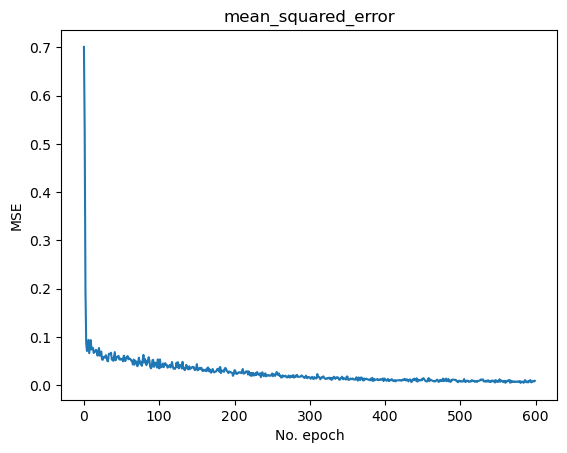

In [49]:
p1=plt.plot(history.history['mean_squared_error'])
#p2=plt.plot(history.history['val_mean_squared_error'])
plt.title('mean_squared_error')
plt.ylabel('MSE')
plt.xlabel('No. epoch')
#plt.yscale('log')
#plt.legend([p1,p2], ['training','validation'])
plt.show()

In [51]:
y_pred_train = model_cnn_lstm.predict(X_train)
y_pred_test = model_cnn_lstm.predict(X_test)


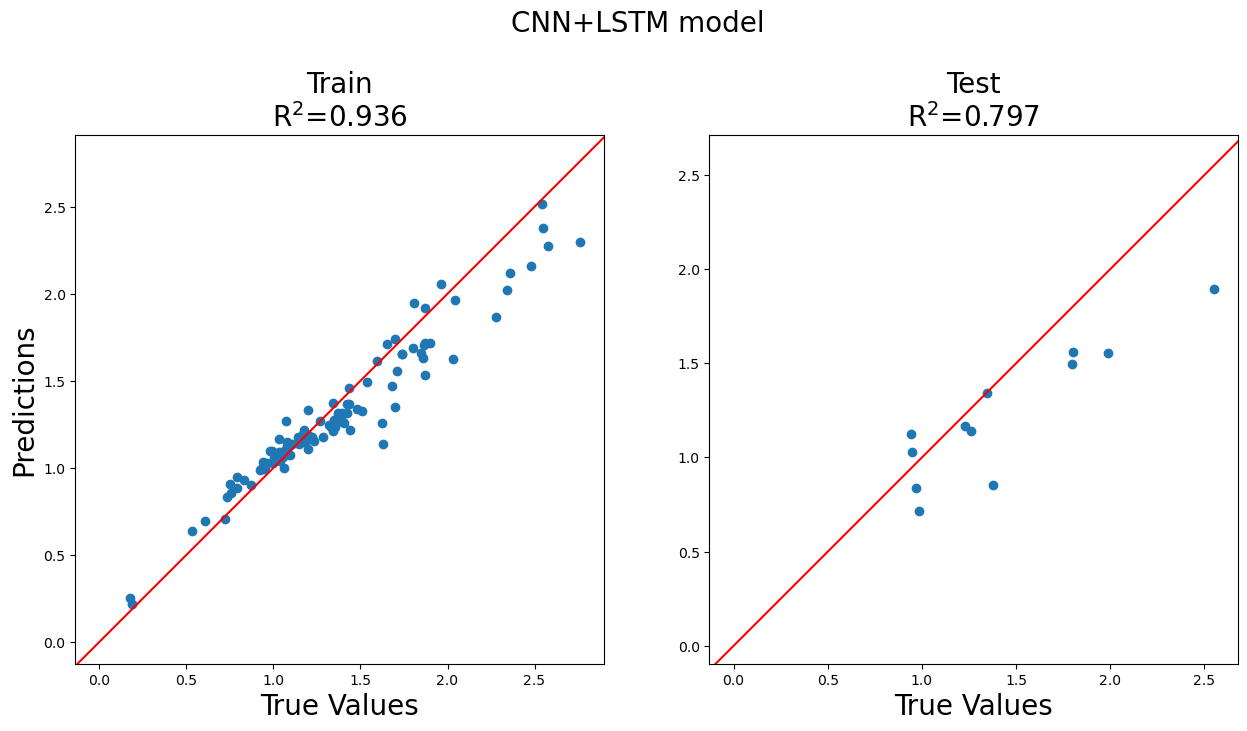

In [52]:
model_name = "CNN+LSTM model"

plot_train_test(model_name,Y_train,y_pred_train,Y_test,y_pred_test)

## CNN+LSTM grid searching

In [21]:
def build_cnn_lstm_model(conv_layers=2,filters=16,kernel_size=3, lstm_units=4, lstm_dropout=0.3, dense_units=16, dense_dropout=0.3, learning_rate=5e-4):
    input_position = Input(shape=(gene_num,), name='input_position')
    reshaped_input = Reshape((gene_num, num_classes))(input_position)
    x = reshaped_input
    ## add conv_layers number of Conv1D layers
    for _ in range(conv_layers):
        x = Conv1D(filters=filters, kernel_size=kernel_size, padding='same', activation='relu')(x)
    x = LSTM(lstm_units, return_sequences=True, dropout=lstm_dropout)(x)
    x = Flatten()(x)
    x = Dense(dense_units, activation='relu')(x)
    x = Dropout(dense_dropout)(x)
    z = Dense(1)(x) 
    model = keras.Model(inputs=input_position, outputs=z)
    model.compile(loss=keras.losses.MeanSquaredError(),
                  optimizer=keras.optimizers.RMSprop(learning_rate=learning_rate),
                  metrics=[tf.keras.metrics.MeanSquaredError()])
    return model



In [54]:

# KerasRegressor is deprecated, use Sci-Keras
#from keras.wrappers.scikit_learn import KerasRegressor
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from keras.callbacks import EarlyStopping


model_cnn_lstm_grid = KerasRegressor(model=build_cnn_lstm_model, 
                                     conv_layers=2,
                                     filters=16,
                                     kernel_size=3, 
                                     lstm_units=4, 
                                     lstm_dropout=0.3, 
                                     dense_units=16, 
                                     dense_dropout=0.3, 
                                     learning_rate=5e-4,
                                     epochs=800, batch_size=20, verbose=1) ## model parameter is needed

# full param grid:
param_grid = {
    'conv_layers': [1,2,3],
    'filters': [8, 16, 32], 
    'kernel_size': [1, 3, 5],
    'lstm_units': [2, 4, 8], # LSTM units
    'dense_units': [8, 16, 32], # Dense layer units
    'learning_rate': [5e-4, 1e-3, 2e-3], # Learning rate
}


#cnn_lstm_grid = GridSearchCV(estimator=model_cnn_lstm_grid, param_grid=param_grid, cv=2,scoring=new_score,verbose=1)  # verbose 
cnn_lstm_grid = GridSearchCV(estimator=model_cnn_lstm_grid, param_grid=param_grid, cv=3,verbose=1)  # verbose 

In [ ]:
cnn_lstm_hist = cnn_lstm_grid.fit(X_train, Y_train, validation_data=(X_test, Y_test),
                      callbacks=[EarlyStopping(patience=80)],verbose=0)

In [56]:
# Best parameters found
print("Best: %f using %s" % (cnn_lstm_hist.best_score_, cnn_lstm_hist.best_params_))

Best: 0.339404 using {'conv_layers': 2, 'dense_units': 32, 'filters': 8, 'kernel_size': 3, 'learning_rate': 0.001, 'lstm_units': 8}


In [23]:
best_params = {'conv_layers': 2, 'dense_units': 32, 'filters': 8, 'kernel_size': 3, 'learning_rate': 0.001, 'lstm_units': 8}

In [73]:
# use build_cnn_lstm_model
model_cnn_lstm_best = build_cnn_lstm_model(**best_params)

#model_cnn_lstm_best = build_cnn_lstm_model(**cnn_lstm_hist.best_params_)
#model_cnn_lstm_best = build_cnn_lstm_model(conv_layers=2,
#                                     filters=8,
#                                     kernel_size=3, 
#                                     lstm_units=4, 
#                                     dense_units=16, 
#                                     learning_rate=5e-4)
history = model_cnn_lstm_best.fit(X_train, Y_train, batch_size=batch_size,  epochs=800,verbose=1)

Epoch 1/800
6/6 [==============================] - 3s 6ms/step - loss: 0.4456 - mean_squared_error: 0.4456
Epoch 2/800
6/6 [==============================] - 0s 6ms/step - loss: 0.1363 - mean_squared_error: 0.1363
Epoch 3/800
6/6 [==============================] - 0s 6ms/step - loss: 0.1197 - mean_squared_error: 0.1197
Epoch 4/800
6/6 [==============================] - 0s 6ms/step - loss: 0.1114 - mean_squared_error: 0.1114
Epoch 5/800
6/6 [==============================] - 0s 6ms/step - loss: 0.0941 - mean_squared_error: 0.0941
Epoch 6/800
6/6 [==============================] - 0s 6ms/step - loss: 0.0758 - mean_squared_error: 0.0758
Epoch 7/800
6/6 [==============================] - 0s 6ms/step - loss: 0.0631 - mean_squared_error: 0.0631
Epoch 8/800
6/6 [==============================] - 0s 6ms/step - loss: 0.0706 - mean_squared_error: 0.0706
Epoch 9/800
6/6 [==============================] - 0s 6ms/step - loss: 0.0794 - mean_squared_error: 0.0794
Epoch 10/800
6/6 [===================

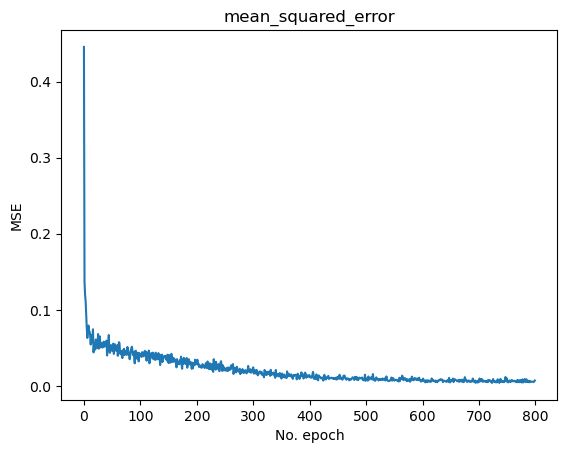

In [74]:
p1=plt.plot(history.history['mean_squared_error'])
#p2=plt.plot(history.history['val_mean_squared_error'])
plt.title('mean_squared_error')
plt.ylabel('MSE')
plt.xlabel('No. epoch')
#plt.yscale('log')
#plt.legend([p1,p2], ['training','validation'])
plt.show()

In [75]:
y_pred_train = model_cnn_lstm_best.predict(X_train)
y_pred_test = model_cnn_lstm_best.predict(X_test)


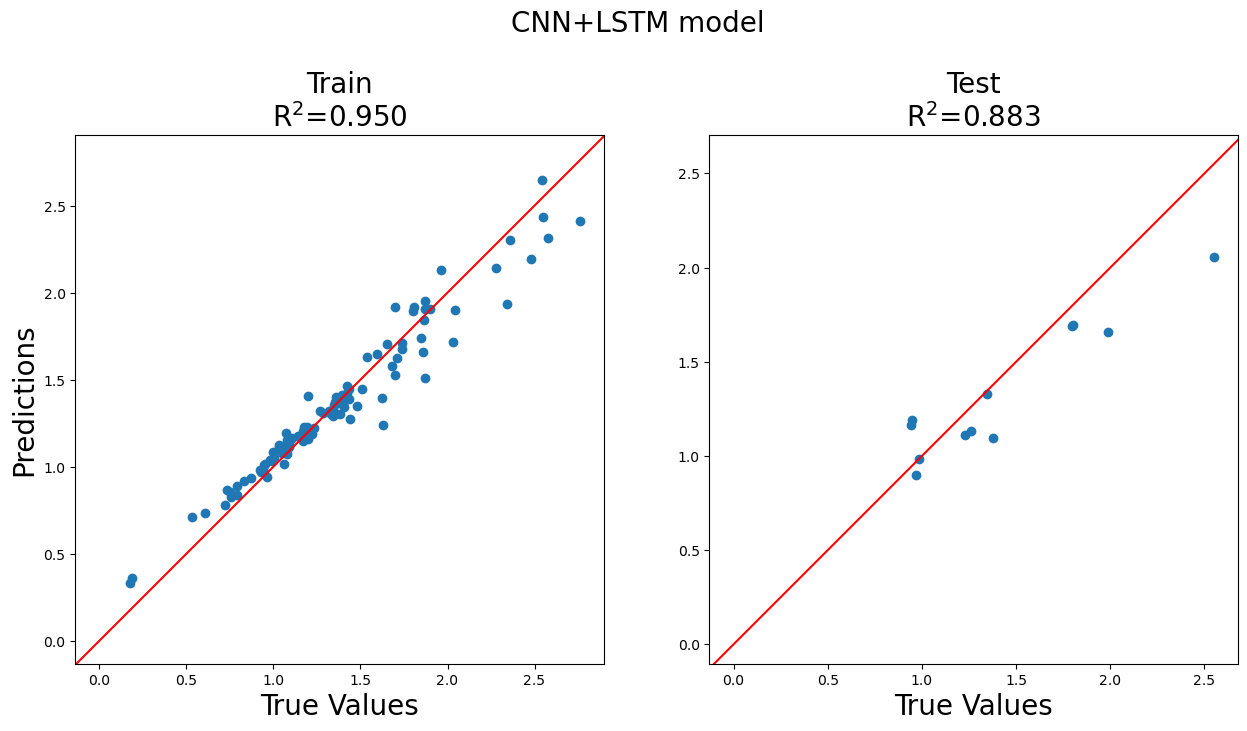

In [148]:
model_name = "CNN+LSTM model"

plot_train_test(model_name,Y_train,y_pred_train,Y_test,y_pred_test)

In [149]:
## save the model
model_cnn_lstm_best.save('save_ML/CNN+LSTM_model_117samples_first_round.h5')

## load saved model

In [22]:
model_cnn_lstm_best = keras.models.load_model('save_ML/CNN+LSTM_model_117samples_first_round.h5')

In [23]:
y_pred_train = model_cnn_lstm_best.predict(X_train)
y_pred_test = model_cnn_lstm_best.predict(X_test)
test_results['CNN_LSTM_model'] = metrics.mean_squared_error(Y_test, y_pred_test)

2024-06-13 04:05:49.338950: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101
2024-06-13 04:05:53.773377: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-06-13 04:05:53.774229: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-06-13 04:05:53.774257: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2024-06-13 04:05:53.775130: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-06-13 04:05:53.775232: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


In [24]:
mse = calculate_mse(Y_test,y_pred_test)
mae = calculate_mae(Y_test,y_pred_test)
r2 = calculate_r2(Y_test,y_pred_test)

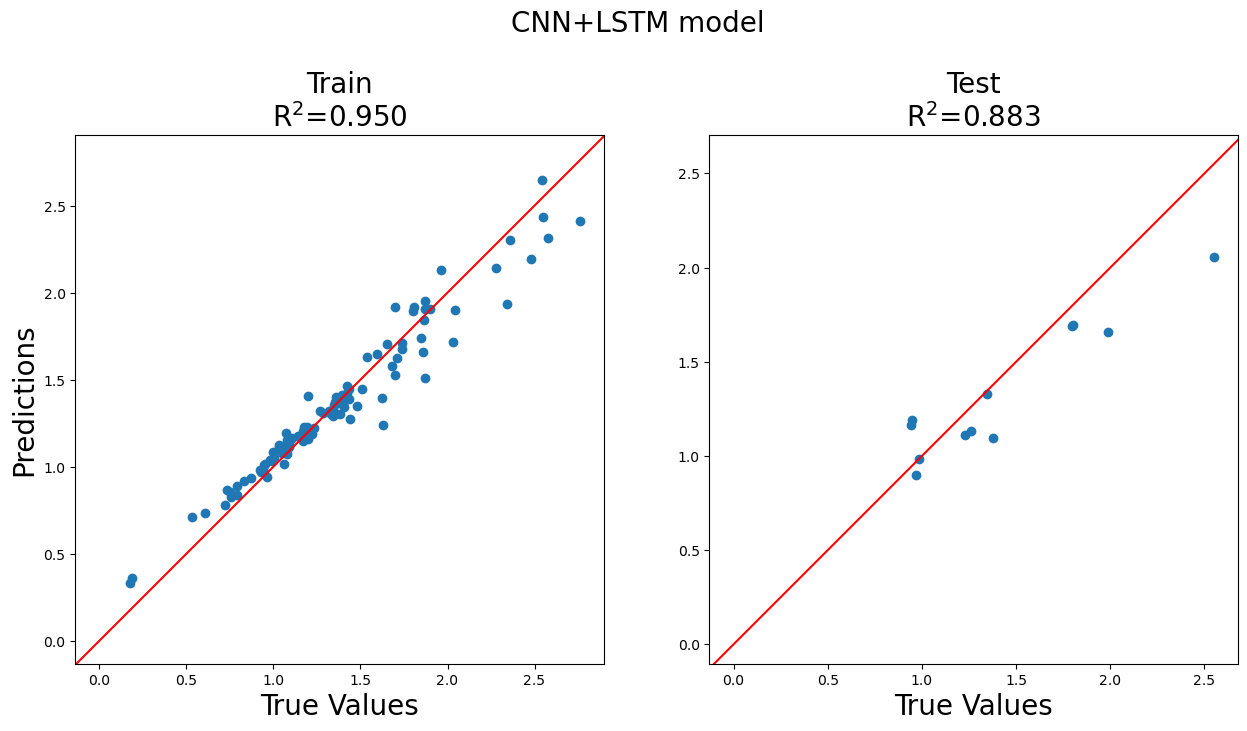

In [25]:
model_name = "CNN+LSTM model"

plot_train_test(model_name,Y_train,y_pred_train,Y_test,y_pred_test)